# Private Support Points: Regression Examples

___

In [1]:
import json
import logging
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.datasets import load_boston, load_diabetes, fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import time

plt.style.use('ggplot')
from matplotlib import rcParams
import pdb


from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    sample_sp_mmd_dp_bw,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

In [2]:
# Set up logging.
log_filename = '../output/regression_logs/run.log'
if os.path.isfile(log_filename):
    os.remove(log_filename)
logging.basicConfig(filename=log_filename,
                             filemode='a',
                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                             datefmt='%H:%M:%S',
                             level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)
_LOG = logging.getLogger('[perturbed]')

# Support points accurately model toy multivariate data in 5D.

In [3]:
def plot_nd(d, w=10, h=10, title=None):
    graph = pd.plotting.scatter_matrix(pd.DataFrame(d), figsize=(w, h));
    if title:
        plt.suptitle(title)
    plt.show()

In [4]:
# Test support points on multivariate Gaussian data.
if 0:
    M = 500
    D = 5
    data = np.random.normal(0, 1, size=(M, D))
    N = 100
    MAX_ITER = 201 #300
    LR = 5e-1 #1e1

    y_opt, e_opt = get_support_points(data, N, MAX_ITER, LR, is_tf=True,
                                      Y_INIT_OPTION='uniform', clip='data')

    plot_nd(pd.DataFrame(data), 5, 5, 'data')
    plot_nd(pd.DataFrame(y_opt), 5, 5, 'sp')

# Given data, repeated support point optimizations are low variance.
# Given support points, repeated diffusions create more variance.

In [5]:
M = 500
N = 50
dim = 2
MAX_ITER = 201
LR = 5e-1
ENERGY_POWER = 2
ALPHA = 10
num_sp_samples = 3
num_diffusions = 3

# Make data.
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]
data = np.random.multivariate_normal(mean, cov, [M])

if 0:

    # ------------------------------------------------------------------
    # Given data, repeated support point optimizations are low variance.
    # ------------------------------------------------------------------

    plt.scatter(data[:, 0], data[:, 1], c='gray', s=64,
                alpha=0.3, label='data')
    for i in range(num_sp_samples):
        y_opt, e_opt = get_support_points(data, N, MAX_ITER, LR, is_tf=True,
                                          Y_INIT_OPTION='uniform', clip='data',
                                          plot=False)
        plt.scatter(y_opt[:, 0], y_opt[:, 1], s=32, label='sp_{}'.format(i))

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()


    # ---------------------------------------------------------------
    # Given support points, repeated diffusions create more variance.
    # ---------------------------------------------------------------

    # Get private support points.
    y_opt, e_opt = get_support_points(data, N, MAX_ITER, LR, is_tf=True,
                                      Y_INIT_OPTION='uniform', clip='data',
                                      plot=False)
    energy_sensitivity = 2 * dim ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
    (y_tildes_diffusion,
     energies_diffusion,
     energy_errors_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                   data, y_opt, 'diffusion',
                                                   step_size=0.01,
                                                   num_y_tildes=num_diffusions,
                                                   alpha=ALPHA,
                                                   diffusion_mean=True)

    plt.scatter(data[:, 0], data[:, 1], c='gray', s=64,
                alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], s=32, c='limegreen',
                label='sp')
    for i in range(num_diffusions):
        y_priv = y_tildes_diffusion[i]
        plt.scatter(y_priv[:, 0], y_priv[:, 1], s=32, label='~sp_{}'.format(i))
    plt.title(('|data|={}, |supp|={}, eps={:.3f}, e_opt: {:.8f}').format(
                   M, N, ALPHA, e_opt))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

___

# Regression task.

In [6]:
def test_regression(data, data_heldout):
    """Computes regression accuracy, averaged over multiple runs.
    
    Each run computes accuracy with k-fold cross validation.
    
    Args:
      data (array): Unnormalized training data.
      data_heldout (array): Unnormalized testing/heldout data.
    
    Returns:
      result (scalar): MSE value on test data.
    """
    
    def regress(X_train, X_test, Y_train, Y_test):
        # Fits linear model given a train-test split.
        # Returns MSE value of fitted model.
        lm = LinearRegression()
        lm.fit(X_train, Y_train)

        Y_pred = lm.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = lm.score(X_test, Y_test)
        
        return mse
    
        
    result = regress(data[:, :-1], data_heldout[:, :-1],
                     data[:, -1], data_heldout[:, -1])
    
    return result
    
    """
    num_runs = 10
    num_folds = 10
    results = []
    
    for _ in range(num_runs):
        # Each run randomly permutes the data.
        permutation = np.random.permutation(len(_X))
        X = np.array(_X)[permutation]
        Y = np.array(_Y)[permutation]

        # Create folds for fitting.
        fold_results = []
        kf = KFold(n_splits=num_folds)
        kf.get_n_splits(X) 

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            
            # Fit model with this fold.
            r2 = regress(X_train, X_test, Y_train, Y_test)
            
            # Store result for this fold.
            fold_results.append(r2)
        
        
        # Store average of fold results.
        results.append(np.mean(fold_results))

    return results
    """

## Helper functions for running experiments.

In [7]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset size alpha mse std tag')


def visualize_data(data, title=None):
    # Visualize data with pairs plot.
    if len(data) >= 1000:
        _d = data[np.random.choice(len(data), 500)]             
        plot_nd(_d, 10, 10, title)
    else:
        plot_nd(data, 10, 10, title)


def round_binary_cols(data, binary_cols):
    """Rounds binary cols of a NumPy array."""
    for col in binary_cols:
        col_data = data[:, col]
        col_data = np.clip(col_data, 0, 1)
        col_data = np.round(col_data)
        data[:, col] = col_data
    return data


def get_accuracy_mean_std_on_heldout(candidate_sets, heldout, data,
                                     dataset_name, N, alpha=None, tag=None):
    """Computes regression accuracy results for a multiset of candidate points.
    
    Multiset can be random subsets of data, can be sets of support points, or
    can be sets of privatized support points.

    Args:
        candidate_sets (array): Multiset of candidate points.
        heldout (array): Array of test data.
        data (array): Data for plotting.
        dataset_name (string): Name of data set.
        N (int): Number of support points.
        alpha (float): Privacy budget.
        tag (string): Tag for Result object.

    Returns:
        result_priv (Result): Named tuple of result for private support points.
    """
    # Collect accuracy values for each diffusion.
    accuracies_diffusion = []
    for candidate_set in candidate_sets:
        accuracy = test_regression(candidate_set, heldout)
        accuracies_diffusion.append(accuracy)
    _LOG.info('accuracies_min_max = {}, {}'.format(min(accuracies_diffusion),
                                                   max(accuracies_diffusion)))
    _LOG.info('accuracies_std = {}'.format(np.std(accuracies_diffusion)))

    # Mean, Std of accuracies across diffusions.
    accuracy_mean = np.round(np.mean(accuracies_diffusion), 4)
    accuracy_std = np.round(np.std(accuracies_diffusion), 4)

    # Store results of diffusion runs for this (N, alpha) combination.
    result = Result(dataset_name, N, alpha, accuracy_mean, accuracy_std, tag)

    # Visualize data versus sample of private support points.
    #visualize_data(data, 'data')
    #visualize_data(candidate_sets[-1], 'N={}, alpha={}'.format(N, alpha))

    return result


def get_energy_sensitivity(data, N, alpha):
    """Computes energy sensitivity.

    Args:
        data (array): Data set, from which dimension will be computed.
        N (int): Number of support points.
        alpha (float): Privacy budget.

    Returns:
        energy_sensitivity (float): Sensitivity value.
    """
    dim = data.shape[1]
    ENERGY_POWER = 2

    # Define energy sensitivity for Exponential Mechanism.
    energy_sensitivity = 2 * dim ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
    print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
           '= Exp({:.3f})').format(energy_sensitivity, alpha, 
                                   2. * energy_sensitivity / alpha))
    _LOG.info(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                  '= Exp({:.3f})').format(energy_sensitivity, alpha, 
                                   2. * energy_sensitivity / alpha))
    
    return energy_sensitivity
                

def resample_from_histdd(H, edge_sets, n=100, plot=False):
    """Resamples data set from histogram, uniformly over bins.
    
    Args:
        H (array): Arrays of counts per bin.
        edge_sets (array): Arrays of edge boundaries per dim.
        n (int): Number of points to sample.

    Returns:
        resampled (array): Newly sampled data.
    """
    bin_widths = [np.diff(edges)[0] for edges in edge_sets]
    midpoints = [edges[:-1] + np.diff(edges) / 2 for edges in edge_sets]

    # Compute CDF of counts, then normalize.
    cdf = np.cumsum(H.ravel())
    cdf = cdf / cdf[-1]
    
    # Sample uniform, associate to CDF values.
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    
    # Fetch associated indices from original grid.
    unraveled_shape = [len(r) for r in midpoints]
    hist_indices = np.array(np.unravel_index(value_bins, unraveled_shape))
    
    # Sample uniformly on bin.
    random_from_cdf = []
    num_dims = len(hist_indices)
    for i in range(num_dims):
        bin_width_i = bin_widths[i]
        mids_i = midpoints[i][hist_indices[i]]
        vals_i = mids_i + np.random.uniform(low=-bin_width_i / 2,
                                            high=bin_width_i / 2,
                                            size=mids_i.shape)
        random_from_cdf.append(vals_i)
    resampled = np.array(random_from_cdf).T
    #random_from_cdf = np.array([midpoints[i][hist_indices[i]] for i in range(num_dims)])
    
    # Visualize data.
    if plot:
        visualize_data(resampled, 'resampled')
        
    return resampled
    
    
def run_experiments(dataset_name, data_orig, binary_cols, num_supp, alphas,
                    max_iter, lr, num_diffusions, step_size):
    """Runs panel of experiments for different number of support points
    and different alpha settings.
    
    Args:
      dataset_name: String name.
      data_orig: NumPy array of data. NOTE: Target var must be last column [!].
      binary_cols: List, column indices with binary variables.
      num_supp: List of support point set sizes.
      alphas: List of alphas.
      max_iter: Int, number of steps in support point optimization.
      lr: Float, learning rate of support point optimization.
      num_diffusions: Int, number of Support Point diffusions over which 
        to average regression performance.
      step_size: Float, step size of support point diffusion.
      
    Returns:
      results: List of Result objects.
    """
    # Shuffle data.
    data = data_orig
    np.random.shuffle(data)
    
    # Split out train and heldout data.
    split = int(0.8 * len(data))
    unnormalized_data_heldout = data[split:]
    unnormalized_data = data[:split]
    visualize_data(unnormalized_data)
    
    # Normalize data.
    _mean = np.mean(unnormalized_data, axis=0)
    _std = np.std(unnormalized_data, axis=0)
    data = (unnormalized_data - _mean) / _std


    results = []

    # --------------------------------------
    # Test regression on FULL TRAINING data.
    # --------------------------------------
    result_training_data = get_accuracy_mean_std_on_heldout(
        [unnormalized_data], unnormalized_data_heldout,
        unnormalized_data, dataset_name, len(unnormalized_data), 
        alpha=None, tag='full_training')
    results.append(result_training_data)
    _LOG.info(result_training_data)

    
    # --------------------------------------------
    # Test regression on PERTURBED HISTOGRAM data.
    # --------------------------------------------
    
    for alpha in alphas:
        n, d = unnormalized_data.shape
        num_bins = (n * alpha / 10) ** ((2 * d) / (2 + d))
        num_bins_per_dim = int(np.round(num_bins ** (1 / d)))  # https://arxiv.org/pdf/1504.05998.pdf

        # Get true histogram, and perturb with Laplace noise.
        H, edges = np.histogramdd(unnormalized_data, bins=num_bins_per_dim)
        
        # Perturb histogram counts with Laplace noise.
        H_perturbed = H + np.random.laplace(loc=0, scale=1/alpha, size=H.shape)
        
        # Resample from perturbed histogram, using uniform sampling per bin.
        perturbed_resample = resample_from_histdd(H_perturbed, edges, n=n)

        # Evaluate regression performance on heldout data.
        result_perturbed_resample = get_accuracy_mean_std_on_heldout(
            [perturbed_resample], unnormalized_data_heldout,
            perturbed_resample, dataset_name, len(perturbed_resample), 
            alpha=alpha, tag='perturbed_resample')
        results.append(result_perturbed_resample)
        _LOG.info(result_perturbed_resample)
    

    # -------------------------------------------
    
    for N in num_supp:

        # -------------------------------------------
        # Test regression on RANDOM SUBSETS (size N).
        # -------------------------------------------
        random_subsets_data = [
            unnormalized_data[np.random.choice(len(unnormalized_data), N)]
            for i in range(num_diffusions)]
        result_random_subsets_data = get_accuracy_mean_std_on_heldout(
            random_subsets_data, unnormalized_data_heldout,
            unnormalized_data, dataset_name, N, alpha=None, tag='random_subset')
        results.append(result_random_subsets_data)
        _LOG.info(result_random_subsets_data)
        
        
        # ------------------------------------------------------
        # Test regression on REPEATED SP optimizations (size N).
        # ------------------------------------------------------
        sp_sets = []
        for i in range(num_diffusions):
            y_opt, e_opt = get_support_points(data, N, max_iter, lr, is_tf=True,
                                              Y_INIT_OPTION='uniform', clip='data',
                                              plot=False)
            y_opt_unnormed = y_opt * _std + _mean
            sp_sets.append(y_opt_unnormed)
        result_sp_sets = get_accuracy_mean_std_on_heldout(
            sp_sets, unnormalized_data_heldout, unnormalized_data,
            dataset_name, N, alpha=None, tag='support_points')
        results.append(result_sp_sets)
        _LOG.info(result_sp_sets)
        
        
        # ---------------------------------------------------
        # Test regression on PRIVATE SUPPORT POINTS (size N).
        # ---------------------------------------------------

        # For each alpha, compute private support points and test regression on them.
        for alpha in alphas:
            print(('\n\n---------------------------'
                   '\nRunning for N={}, alpha={}').format(N, alpha))
            _LOG.info('Running for N={}, alpha={}'.format(N, alpha))
            
            # TODO: TESTING FIXED STEP SIZES BASED ON ALPHA.
            #if alpha <= 1:
            #    step_size = 0.05
            #elif alpha <= 10:
            #    step_size = 0.01
            #else:
            #    step_size = 0.005
            if alpha <= 1:
                step_size = 0.1
            elif alpha <= 10:
                step_size = 0.05
            else:
                step_size = 0.025


            # -------------------------------   
            # Compute private support points.
            # -------------------------------   
            
            energy_sensitivity = get_energy_sensitivity(data, N, alpha)

            # For this (N, alpha) combo, run [mean energy] diffusion many times.
            # Resulting accuracy values will be averaged.
            (y_tildes_diffusion,
             energies_diffusion,
             energy_errors_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                           data, y_opt, 'diffusion',
                                                           step_size=step_size,
                                                           num_y_tildes=num_diffusions,
                                                           alpha=alpha,
                                                           diffusion_mean=True)

            unnormalized_private_sps = y_tildes_diffusion * _std + _mean

            # Impose boolean values for certain columns in SPs.
            #unnormalized_private_sps = ([
            #    round_binary_cols(i, binary_cols) for i in unnormalized_private_sps])

            
            # ------------------------------------------   
            # Test regression on private support points.
            # ------------------------------------------
            
            result = get_accuracy_mean_std_on_heldout(unnormalized_private_sps,
                                                      unnormalized_data_heldout,
                                                      unnormalized_data,
                                                      dataset_name, N, alpha=alpha,
                                                      tag='private_support_points')
            results.append(result)
            _LOG.info(result)



            
    return results  

___

# Full Experiments.

In [8]:
run_boston = 1
run_diabetes = 0
run_california = 0

alphas = [100, 10, 1]
num_diffusions = 5

global_results = []

## BOSTON

In [9]:
# Get Boston data.
dataset_name = 'boston'
dataset = load_boston()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['MEDV'] = dataset.target
binary_cols = [3]
#print(dataset.DESCR)
#print(d.describe())

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
#data = data[np.random.choice(len(data), 100, replace=False)]
np.random.shuffle(data)
data = data[:, [1, 2, 3]]

In [10]:
# Define set of parameters to test.
num_supp = [int(len(data) * i / 10) for i in range(1, 11, 2)] 
max_iter = 301
lr = 0.5
step_size = 1e-3

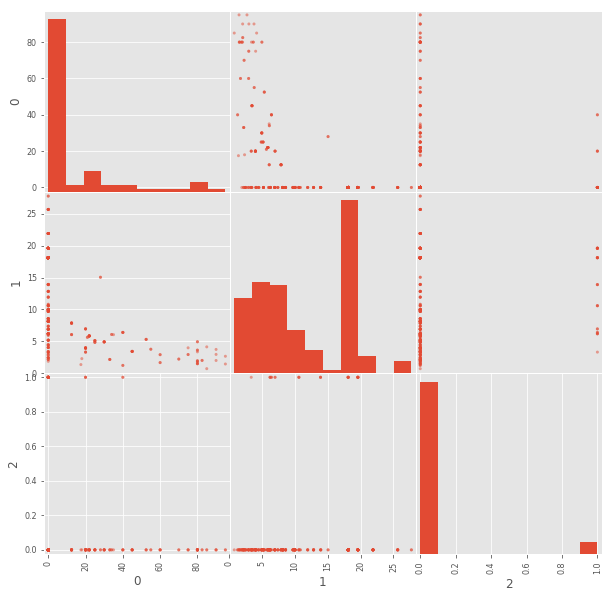


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Time elapsed: 0.92

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.92

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.03

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.86

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.81


---------------------------
Running for N=50, alpha=100
Exp(2 * U / alpha) = Exp(2 * 0.1372 / 100.00) = Exp(0.003)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.1372 / 100.000) = Exp(0.0027)

Using diffusion me

  Diffusion count    12, e_opt:  0.059791, (e(y, y~) - e~) / e~ = error%: (0.00987 - 0.00915) / 0.00915 = 0.07871
Using diffusion mean:

Exp. mean: 0.00915, e_tilde: 0.00915
  step_size_factor: 1.00000, adjusted: 0.05 -> 0.05000
  Diffusion count     9, e_opt:  0.059791, (e(y, y~) - e~) / e~ = error%: (0.01232 - 0.00915) / 0.00915 = 0.34688


---------------------------
Running for N=151, alpha=1
Exp(2 * U / alpha) = Exp(2 * 0.0457 / 1.00) = Exp(0.091)

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.0457 / 1.000) = Exp(0.0915)

Using diffusion mean:

Exp. mean: 0.09146, e_tilde: 0.09146
  step_size_factor: 1.00000, adjusted: 0.1 -> 0.10000
  Diffusion count    16, e_opt:  0.059791, (e(y, y~) - e~) / e~ = error%: (0.09269 - 0.09146) / 0.09146 = 0.01345
Using diffusion mean:

Exp. mean: 0.09146, e_tilde: 0.09146
  step_size_factor: 1.00000, adjusted: 0.1 -> 0.10000
  Diffusion count    15, e_opt:  0.059791, (e(y, y~) - e~) / e~ = error%: (0.09347 - 0.09146) / 0.09146 = 0.

  Diffusion count     6, e_opt:  0.085884, (e(y, y~) - e~) / e~ = error%: (0.00517 - 0.00391) / 0.00391 = 0.32162
Using diffusion mean:

Exp. mean: 0.00391, e_tilde: 0.00391
  step_size_factor: 1.00000, adjusted: 0.05 -> 0.05000
  Diffusion count     7, e_opt:  0.085884, (e(y, y~) - e~) / e~ = error%: (0.00478 - 0.00391) / 0.00391 = 0.22400
Using diffusion mean:

Exp. mean: 0.00391, e_tilde: 0.00391
  step_size_factor: 1.00000, adjusted: 0.05 -> 0.05000
  Diffusion count     5, e_opt:  0.085884, (e(y, y~) - e~) / e~ = error%: (0.00416 - 0.00391) / 0.00391 = 0.06481
Using diffusion mean:

Exp. mean: 0.00391, e_tilde: 0.00391
  step_size_factor: 1.00000, adjusted: 0.05 -> 0.05000
  Diffusion count     5, e_opt:  0.085884, (e(y, y~) - e~) / e~ = error%: (0.00469 - 0.00391) / 0.00391 = 0.20109
Using diffusion mean:

Exp. mean: 0.00391, e_tilde: 0.00391
  step_size_factor: 1.00000, adjusted: 0.05 -> 0.05000
  Diffusion count     6, e_opt:  0.085884, (e(y, y~) - e~) / e~ = error%: (0.00452 -

In [11]:
# Run experiments and print results.
if run_boston:
    np.random.seed(123)
    results = run_experiments(dataset_name, data, binary_cols, num_supp,
                              alphas, max_iter, lr, num_diffusions, step_size)
    
    global_results.extend(results)

## DIABETES

In [12]:
# Get diabetes data.
dataset_name = 'diabetes'
dataset = load_diabetes()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['TARGET'] = dataset.target
#print(dataset.DESCR)
#print(d.describe())
binary_cols = []

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
#data = data[np.random.choice(len(data), 100, replace=False)]
np.random.shuffle(data)

In [13]:
# Define set of parameters to test.
num_supp = [int(len(data) * i / 10) for i in range(1, 11, 2)] 
max_iter = 301
lr = 0.5
step_size = 1e-3

In [14]:
# Run experiments and print results.
if run_diabetes:
    np.random.seed(123)
    results = run_experiments(dataset_name, data, binary_cols, num_supp,
                              alphas, max_iter, lr, num_diffusions, step_size)
    
    global_results.extend(results)

## CALIFORNIA

In [15]:
# Get diabetes data.
dataset_name = 'california'
dataset = fetch_california_housing()
d = pd.DataFrame(dataset.data)
d.columns = dataset.feature_names
d['TARGET'] = dataset.target
#print(dataset.DESCR)
#print(d.describe())
binary_cols = []

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = data[np.random.choice(len(data), 500, replace=False)]
np.random.shuffle(data)

In [16]:
# Define set of parameters to test.
num_supp = [int(len(data) * i / 10) for i in range(1, 11, 2)] 
max_iter = 1001
lr = 1.
step_size = 5e-4

In [17]:
# Run experiments and print results.
if run_california:
    np.random.seed(123)
    results = run_experiments(dataset_name, data, binary_cols, num_supp,
                              alphas, max_iter, lr, num_diffusions, step_size)

    global_results.extend(results)

___

# Save and plot global results

In [18]:
import json
gr_as_dict = [row._asdict() for row in global_results]
with open('../output/regression_global_results.json', 'w') as outfile:
    json.dump(gr_as_dict, outfile)

In [19]:
import json
with open('../output/regression_global_results.json') as json_file:
    gr = json.load(json_file)

print(gr[:5])

[{'tag': 'full_training', 'size': 404, 'dataset': 'boston', 'std': 0.0, 'mse': 0.0736, 'alpha': None}, {'tag': 'perturbed_resample', 'size': 404, 'dataset': 'boston', 'std': 0.0, 'mse': 0.0745, 'alpha': 100}, {'tag': 'perturbed_resample', 'size': 404, 'dataset': 'boston', 'std': 0.0, 'mse': 0.0742, 'alpha': 10}, {'tag': 'perturbed_resample', 'size': 404, 'dataset': 'boston', 'std': 0.0, 'mse': 0.0877, 'alpha': 1}, {'tag': 'random_subset', 'size': 50, 'dataset': 'boston', 'std': 0.0021, 'mse': 0.0779, 'alpha': None}]


In [20]:
def dict_filter_tag(rows, query, dataset, tag):
    """Gets results. Note: As saved, ordered by increasing N."""
    r = [d[query] for d in rows if d['dataset'] == dataset and d['tag'] == tag]
    return r

def dict_filter_alpha(rows, query, dataset, alpha):
    """Gets results. Note: As saved, ordered by increasing N."""
    r = [d[query] for d in rows if d['dataset'] == dataset and
                                   d['tag'] == 'private_support_points' and
                                   d['alpha'] == alpha]
    return r

In [23]:
def plot_global_results(dataset, up_to_index=5):
    u = up_to_index
    tag = 'full_training'
    mse_to_plot = dict_filter_tag(gr, 'mse', dataset, tag)
    x = np.linspace(0.1, 1, 5)
    plt.hlines(mse_to_plot, 0.1, 1 * u / 10, label='full_training')

    for tag in ['random_subset', 'support_points']:
        mse_to_plot = dict_filter_tag(gr, 'mse', dataset, tag)
        std_to_plot = dict_filter_tag(gr, 'std', dataset, tag)
        plt.errorbar(x[:u], mse_to_plot[:u], yerr=std_to_plot[:u], label=tag)
    
    for alpha in alphas:
        mse_to_plot = dict_filter_alpha(gr, 'mse', dataset, alpha)
        std_to_plot = dict_filter_alpha(gr, 'std', dataset, alpha)
        plt.errorbar(x[:u], mse_to_plot[:u], yerr=std_to_plot[:u],
                     label=r'sp, $\alpha={}$'.format(alpha))
        
        # Also plot perturbed resample.
        mse_pert = [d['mse'] for d in gr if 
                        d['dataset'] == dataset and
                        d['tag'] == 'perturbed_resample' and
                        d['alpha'] == alpha]
        std_pert = [d['std'] for d in gr if 
                        d['dataset'] == dataset and
                        d['tag'] == 'perturbed_resample' and
                        d['alpha'] == alpha]
        plt.hlines(mse_pert, 0.1, 1 * u / 10, label=r'pert_$\alpha={}$'.format(alpha))
        

    plt.xlabel('Number of Points, Fraction of Whole')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.savefig('../output/regression_global_results_{}'.format(dataset))
    plt.show()
    

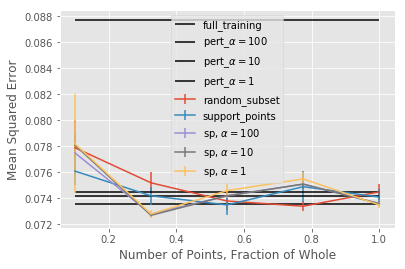

ValueError: shape mismatch: objects cannot be broadcast to a single shape

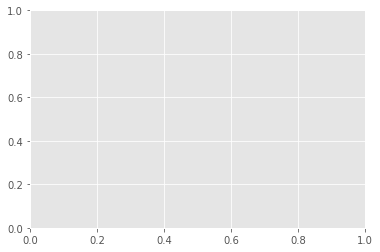

In [24]:
if len(global_results) > 0:
    plot_global_results('boston', 10)
    plot_global_results('diabetes', 10)
    plot_global_results('california', 10)

___

___

In [ ]:
sys.exit()

In [ ]:
privacy_budget = .1

d = data[:, [6,7]]
visualize_data(d, 'data')
H, edges_all_dims = np.histogramdd(d, bins=32)


resampled = resample_from_histdd(H, edges_all_dims, n=500)
H_perturbed = H + np.random.laplace(loc=0, scale=1/privacy_budget, size=H.shape)
resampled_priv = resample_from_histdd(H_perturbed, edges_all_dims, n=500)